# SherLock, Malware Detection in Androids without Root Privileges

<span style="color:red">You should be in a PySpark docker image to run this notebook!</span>  
If you're not in PySpark, please run the following (presuming you have docker installed)

In [ ]:
!docker run -it --rm -p 8888:8888 jupyter/pyspark-notebook

If you need help, check out [this link](https://medium.com/@suci/running-pyspark-on-jupyter-notebook-with-docker-602b18ac4494)

# Sherlock: Classifying Malicious Cell Phone Sessions 

This subset of the well-known Sherlock dataset contains data extracted from 37 user's cell phones across 3 months at the beginning of 2016. There are two tables involved in this analysis:  
T4.tsv: ~26Gb of data on battery level, memory usage, packet inflows and outflows and the like. Each row represents a scan, and scans are conducted every 5 seconds. 
Moriartyprobe.tsv: ~65Mb of data from an app called Moriarty which starts "sessions", a variety of realistic of attacks on the user's cellphone that stop and start intermittently. The sessions are either benign or malicious.  

Our model will explore these 5 second chunks of times as independent observations, enabling the development of a binary classification learning model that can be implemented to track T4 cell phone usage stats in real time to identify whether an attack is occurring and signal the user.  

In order to use this dataset in a Spark ML pipeline, it must be imported, transformed, cleaned, subsetted, then both tables must be combined. The code below uses awk, PySpark, and the SparkSQL api to do all of that.  

## First: Grab the T4 data from my personal dropbox. The links below will automatically download

I'm not paying 11.99 a month for nothing!

<span style="color:red">WARNING: T4 is very large. 25.66Gbs to be exact. Please check your disk space before downloading the files.</span>  

[T4.tsv](https://www.dropbox.com/s/ran3lbrs756w2hn/T4.tsv?dl=1) (26Gb)  

## Second: Grab the Moriarty Probe data from my personal dropbox. 

[Moriartyprobe.tsv](https://www.dropbox.com/s/epbcz9wg3nl0twi/Moriartyprobe.tsv?dl=1) (65.2MB)

## Third: Drag and Drop both T4.tsv or T4randomsample.tsv and Moriartyprobe.tsv  in the folder labeled "tsvs"

This step is very important, or else the filepaths below will not work (and you will feel like pulling your hair out trying to fix them). Or you'll be really upset with me. Neither is good.

In [ ]:
# Verify that your working directory is "SherLock"
!pwd

/home/jovyan/SherLock


In [ ]:
# I use an awk script to do the transformations. It can be viewed at /Sherlock/import.awk
!cat import.awk
# change permissions to make file executable
!chmod +x import.awk

#!/usr/bin/awk -f
BEGIN { FS="\t"; OFS="," } { 
  if (FILENAME ~ /T4/){ 
    rebuilt=0 
    for(i=1; i<=NF; ++i) { 
      if ($i ~ /Hz/){ 
        $i = ($i + 0) 
        if ($i > 100) {$i*=.001} 
      } 
      if ($i ~ /,/ && $i !~ /^".*"$/) { 
        gsub("\"", "\"\"", $i) 
        $i = "\"" $i "\"" 
        rebuilt=1 
      } 
    } 
    if (!rebuilt) { $1=$1 } 
    print $1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12,$13,$14,$15,$16,$17,$18,$19,$20,$21,$22,$23,$24,$25,$26 
  } 
  else if (FILENAME ~ /Mor/) { 
    rebuilt=0 
    for(i=1; i<=NF; ++i) 
      if ($i ~ /,/ && $i !~ /^".*"$/) { 
        gsub("\"", "\"\"", $i) 
        $i = "\"" $i "\"" 
        rebuilt=1 
      } 
    if (!rebuilt) { $1=$1 } 
    print $1,$2,$3,$4,$5,$6,$7,$8 
  } 
} 

<span style="color:red">If you used the dataset T4randomsample.tsv instead of T4.tsv, change the line "tsvs/T4.tsv" to "tsvs/T4randomsample.tsv"</span>

## Fourth: Transform the datasets using awk streaming language

Fun fact, this language was developed in 1977 by AT&T! It's still surprisingly useful today for data extraction and reporting.   
I'm using a script called import.awk to make all transformations  
This next code calls that script, and prints its results to a new file in the correct part of the filesystem.  
The changes made are as follows:  
1. Change the delimiter from tabs (\t) to commas (,)
2. If the filename contains T4, change the Hz column to be numeric, and if the number is larger than 100, it means that the value was labeled in MHz, and it is to be reduced by a factor of 100.  The rest are null.
3. Else if the filename contains Mor, don't do the GHz transformation. 
3. If either file incidentally has any misplaced delimiter values (such as stray commas, quotation marks, or back slashes), fix them!
4. Print out a subset of columns (1-26) for T4.tsv, and a subset of columns (1-8) for Moriartyprobe.tsv. 
5. There should now be two trasformed, useable tsv files in the correct folders


In [ ]:
# Command line script using awk to remove null columns and transform to both T4 and Moriartyprobe to csv format. 
# Also removes Hz labels from Hz columns, and makes consistent the units of the Hz column in T4.  
!./import.awk \
tsvs/T4randomsample.tsv \
    > csvs/T4subset.csv 
!./import.awk \
tsvs/Moriartyprobe.tsv \
    > csvs/Moriartyprobe.csv

## Fifth: Load PySpark for further transformations
Use !pip install to install anything you are missing

In [1]:
# Import pyspark
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession
from functools import reduce
import pandas as pd
import numpy as np
import sklearn

In [3]:
# Start a session 
spark = SparkSession.builder.master('local[2]').config("spark.executor.memory", "2g").config("spark.driver.memory", "2g").appName('spark_sh_data').getOrCreate()

In [4]:
# Import data: t4 and Moriarty
t4 = spark.read.options(header=True, nullValue='NULL', inferSchema=True).csv('csvs/T4subset.csv')
mor = spark.read.options(header=True, nullValue='NULL', inferSchema=True).csv('csvs/Moriartyprobe.csv')

## Sixth: Add column names to csv files

In [5]:
# create colnames T4
t4_colnames = ['userid', 'uuid', 'Version', 'CpuGHz', 'CPU_0', 'CPU_1', 'CPU_2', 'CPU_3', 'Total_CPU', 'TotalMemory_freeSize', 'TotalMemory_max_size',
'TotalMemory_total_size', 'TotalMemory_used_size', 'Traffic_MobileRxBytes', 'Traffic_MobileRxPackets', 'Traffic_MobileTxBytes',
'Traffic_MobileTxPackets','Traffic_TotalRxBytes', 'Traffic_TotalRxPackets', 'Traffic_TotalTxBytes', 'Traffic_TotalTxPackets',
'Traffic_TotalWifiRxBytes', 'Traffic_TotalWifiRxPackets', 'Traffic_TotalWifiTxBytes', 'Traffic_TotalWifiTxPackets',
'Traffic_timestamp', 'Battery_charge_type', 'Battery_current_avg']

# create colnames Moriarty 
mor_colnames = ['userid', 'uuid', 'actionType', 'action', 'behavior', 'sessionType', 'sessionID', 'version']
# Add column names
t4_oldColumns = t4.schema.names
t4_newColumns = t4_colnames

mor_oldColumns = mor.schema.names
mor_newColumns = mor_colnames


t4 = reduce(lambda t4, idx: t4.withColumnRenamed(t4_oldColumns[idx], t4_newColumns[idx]), range(len(t4_oldColumns)), t4)
mor = reduce(lambda mor, idx: mor.withColumnRenamed(mor_oldColumns[idx], mor_newColumns[idx]), range(len(mor_oldColumns)), mor)
t4.printSchema()
mor.printSchema()

root
 |-- userid: string (nullable = true)
 |-- uuid: long (nullable = true)
 |-- Version: string (nullable = true)
 |-- CpuGHz: string (nullable = true)
 |-- CPU_0: string (nullable = true)
 |-- CPU_1: string (nullable = true)
 |-- CPU_2: string (nullable = true)
 |-- CPU_3: string (nullable = true)
 |-- Total_CPU: string (nullable = true)
 |-- TotalMemory_freeSize: string (nullable = true)
 |-- TotalMemory_max_size: string (nullable = true)
 |-- TotalMemory_total_size: string (nullable = true)
 |-- TotalMemory_used_size: string (nullable = true)
 |-- Traffic_MobileRxBytes: string (nullable = true)
 |-- Traffic_MobileRxPackets: string (nullable = true)
 |-- Traffic_MobileTxBytes: string (nullable = true)
 |-- Traffic_MobileTxPackets: string (nullable = true)
 |-- Traffic_TotalRxBytes: string (nullable = true)
 |-- Traffic_TotalRxPackets: string (nullable = true)
 |-- Traffic_TotalTxBytes: string (nullable = true)
 |-- Traffic_TotalTxPackets: string (nullable = true)
 |-- Traffic_Total

In [7]:
# verify successful import
import pandas as pd
pd.set_option('display.max_columns', None)
mor.show(5)

+----------+-------------+--------------------+-------------------+--------+-----------+---------+-------+
|    userid|         uuid|          actionType|             action|behavior|sessionType|sessionID|version|
+----------+-------------+--------------------+-------------------+--------+-----------+---------+-------+
|0a50e09262|1451638991449|App entered onPau...|    App Mode change|  benign|     benign|      1.0|     21|
|0a50e09262|1451637887475|Application enter...|Application started|  benign|     benign|      1.0|     21|
|0a50e09262|1451637887633|User started to p...|        Game stared|  benign|     benign|      1.0|     21|
|0a50e09262|1451637921510|App entered onPau...|    App Mode change|  benign|     benign|      1.0|     21|
|0a50e09262|1451638167470|App entered onResume|    App Mode change|  benign|     benign|      1.0|     21|
+----------+-------------+--------------------+-------------------+--------+-----------+---------+-------+
only showing top 5 rows



## Seventh: Join the t4 and Moriarty datasets. They do not share a common key. 
This is a critical move, and a challenging one. I will need to join the tables based on the uuid values, only joining values which are within the same range of time period. UUID is measured in milliseconds, so I will distribute labels of malicious or benign across the time ranges.
Utilizing a CTE, a window function, and a subquery, I successfully joined the two tables. 
Steps taken in the SQL Join:  
1. Create a Subquery table called "sub", which contains the uuid, sessionType, a new index column created with count(m.sessionType) over uuid, named m_grp, all selected from full - joining t4 and Moriarty.  
2. From "sub", select select uuid, the minimum of each m_grp (which will populate the same value over and over for each m_grp) as sessionType. <-- This is the main step.  
3. Select everything from this table, then join back the original t4 on the uuids, which excludes any duplicates from the table.  

If you desire a simple, foobar like stack overflow explanation of the general logic behind what I did, check out [this SO answer](https://dba.stackexchange.com/questions/105736/combine-two-event-tables-into-a-single-timeline). I built on this answer by using a CTE, so that I could join the two tables only on values found in the original t4 dataset. I didn't want duplicate values for any T4 data. 

In [44]:
# create temp table 
t4.createOrReplaceTempView('t4')
mor.createOrReplaceTempView('mor')
t4_mor = spark.sql("""
with CTE as (SELECT uuid
    , min(sessionType) OVER (PARTITION BY m_grp) as sessionType
FROM (
    SELECT uuid, m.sessionType 
        , count(m.sessionType) OVER (ORDER BY uuid) as m_grp
    FROM mor m
    FULL OUTER JOIN t4 t using(uuid)
    ) sub)
SELECT * 
FROM CTE
JOIN t4 using(uuid);
""")

## Eighth: Verify that the dataframe has both a sessionType column populated with values, and a bunch of cell data like CPU and Memory stats

In [13]:
t4_mor.show(5)

+-------------+-----------+----------+-------+------+--------+---------+--------+---------+---------+--------------------+--------------------+----------------------+---------------------+---------------------+-----------------------+---------------------+-----------------------+--------------------+----------------------+--------------------+----------------------+------------------------+--------------------------+------------------------+--------------------------+--------------------+
|         uuid|sessionType|    userid|Version|CpuGHz|   CPU_0|    CPU_1|   CPU_2|    CPU_3|Total_CPU|TotalMemory_freeSize|TotalMemory_max_size|TotalMemory_total_size|TotalMemory_used_size|Traffic_MobileRxBytes|Traffic_MobileRxPackets|Traffic_MobileTxBytes|Traffic_MobileTxPackets|Traffic_TotalRxBytes|Traffic_TotalRxPackets|Traffic_TotalTxBytes|Traffic_TotalTxPackets|Traffic_TotalWifiRxBytes|Traffic_TotalWifiRxPackets|Traffic_TotalWifiTxBytes|Traffic_TotalWifiTxPackets|   Traffic_timestamp|
+-----------

In [14]:
# Looks like there's null values. Those are values outside of the time range of the samples. Let's drop 'em, to ensure a full dataset. 
t4_mor = t4_mor[t4_mor['sessionType'] != ""]

In [16]:
# Check how many of each sessionType we have
t4_mor.groupBy('sessionType').count().show()

+-----------+-----+
|sessionType|count|
+-----------+-----+
|     benign|17074|
|  malicious|82936|
+-----------+-----+



# Machine Learning Steps in PySpark 

In [94]:
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator


from pyspark.sql import SparkSession
from pyspark.sql.functions import translate
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer

from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
import pandas as pd
import numpy as np
from pyspark.ml.linalg import Vectors
import pyspark.ml.evaluation as ev

from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [76]:
# Once you have uploaded your data we will now need to translate the NULL values to '' 
newDf = t4_mor.withColumn('CPU_1', translate('CPU_1', 'NULL', '')).withColumn('CPU_2', translate('CPU_2', 'NULL', '')).withColumn('CPU_3', translate('CPU_3', 'NULL', '')).withColumn('Total_CPU', translate('Total_CPU', 'NULL', ''))\
    .withColumn('TotalMemory_freeSize', translate('TotalMemory_freeSize', 'NULL', ''))
# With the NULL values now as '' we can change the column type to and Integer to allow for analysis 
df = newDf.withColumn('CpuGHz', newDf["CpuGHz"].cast(IntegerType())).withColumn('CPU_0', newDf["CPU_0"].cast(IntegerType())).withColumn('CPU_1', newDf["CPU_1"].cast(IntegerType())).withColumn('CPU_2', newDf["CPU_2"].cast(IntegerType())).withColumn('CPU_3', newDf["CPU_3"].cast(IntegerType()))\
    .withColumn('Traffic_MobileRxBytes', newDf["Traffic_MobileRxBytes"].cast(IntegerType()))\
    .withColumn('Traffic_MobileRxPackets', newDf["Traffic_MobileRxPackets"].cast(IntegerType()))\
    .withColumn('Traffic_MobileTxBytes', newDf["Traffic_MobileTxBytes"].cast(IntegerType()))\
    .withColumn('Traffic_MobileTxPackets', newDf["Traffic_MobileTxPackets"].cast(IntegerType()))\
    .withColumn('Traffic_TotalWifiRxBytes', newDf["Traffic_TotalWifiRxBytes"].cast(IntegerType()))\
    .withColumn('Traffic_TotalWifiRxPackets', newDf["Traffic_TotalWifiRxPackets"].cast(IntegerType()))\
    .withColumn('Traffic_TotalWifiTxBytes', newDf["Traffic_TotalWifiTxBytes"].cast(IntegerType()))\
    .withColumn('Traffic_TotalWifiTxPackets', newDf["Traffic_TotalWifiTxPackets"].cast(IntegerType()))





### Define a function which returns the shape of a pySpark dataframe

In [77]:
import pyspark 
def spark_shape(self):
    return (self.count(), len(self.columns))
pyspark.sql.dataframe.DataFrame.shape = spark_shape


In [78]:
df = df.dropDuplicates()
spark_shape(df)

(99990, 27)

### Remove all Recieved and Transfered Bytes/Packets that are = 0

In [79]:
df = df.filter((df.Traffic_MobileRxBytes != 0)&(df.Traffic_MobileRxPackets != 0)&(df.Traffic_MobileTxBytes != 0)&(df.Traffic_MobileTxPackets != 0)&(df.Traffic_TotalRxBytes != 0)
                   &(df.Traffic_TotalRxPackets != 0)&(df.Traffic_TotalTxBytes != 0)&(df.Traffic_TotalTxPackets != 0)&(df.Traffic_TotalWifiRxBytes != 0)&(df.Traffic_TotalWifiRxPackets != 0)
                   &(df.Traffic_TotalWifiTxBytes != 0)&(df.Traffic_TotalWifiTxPackets != 0))

## The Pipeline

### Step One: Build the Assembler using a VectorAssembler
A vector assembler combines multiple vectors into a single row-vector; that is, where each row element of the newly generated column is a vector formed by concatenating each row element from the specified input features

In [80]:
assembler = VectorAssembler().setInputCols(['CpuGHz', 'CPU_0', 'CPU_1','CPU_2', 'CPU_3', 
                        #'Total_CPU', #'TotalMemory_freeSize',
                        #'TotalMemory_max_size', 'TotalMemory_total_size',
                        #'TotalMemory_used_size', 
                        'Traffic_MobileRxBytes', 'Traffic_MobileRxPackets', 'Traffic_MobileTxBytes', 'Traffic_MobileTxPackets', 
                        #'Traffic_TotalRxBytes', 'Traffic_TotalRxPackets', 'Traffic_TotalTxBytes', 'Traffic_TotalTxPackets', 
                        'Traffic_TotalWifiRxBytes', 'Traffic_TotalWifiRxPackets', 'Traffic_TotalWifiTxBytes', 'Traffic_TotalWifiTxPackets'])\
                        .setOutputCol("vectorized_features").setHandleInvalid("skip")
assembler_df = assembler.transform(df)

### Step Two: Build the Label Indexer using the StringIndexer function
The StringIndexer function is a label indexer that maps a string column of labels to an ML column of label indices. For this we use the sessionType variable as our input column and then set the output column to label. Inside the label column was a dichotomous variable encoding 1 to malicious applications and 0 to benign applications. 

In [81]:
label_indexer = StringIndexer().setInputCol("sessionType").setOutputCol("label")

### Step Three: Scale the vectorized_features using the StandardScaler function
The StandardScaler standardizes a set of features to have zero mean and a standard deviation of 1. What this meant for the SherLock is that for all of our input features that are listed above that we put into the vectorized_features were now scaled down to be between -1 and 1 allowing our data to be standardized.

In [82]:
scaler = StandardScaler().setInputCol("vectorized_features").setOutputCol("features")

### Step Four: Set the Stages for the Pipeline then Fit and Transform the data into the Pipeline

In [84]:
pipeline_stages=Pipeline().setStages([assembler,label_indexer,scaler])
pipeline_model=pipeline_stages.fit(df)
pipeline_df=pipeline_model.transform(df)

### Step Five: Filter out duplicate values and check the shape of the Dataframe

In [85]:
pipeline_df = pipeline_df.filter(pipeline_df.label != 2.0)

In [86]:
spark_shape(pipeline_df)

(459, 30)

## Machine Learning Models & Evaluation

### Logistic Regression
Logistic regression is utilized to find a prediction in the presence of the input features such as packet transfer levels and hardware performance counters. The process is very similar to a multiple linear regression, with the exception that the response variable is a dichotomous (binary) variable. Logistic regression is a relatively fast supervised classification model compared to the other methods we used in our analysis but where it gains speed it also suffers to some degree in its accuracy. This was extremely important for analyzing the Moriarty data frame since it consisted of 37 million rows and 30 different columns which when running through a model would take a very long time to run. 

In [87]:
# We decided to use a 80/20 split to maximize the amount of data that was input into the training set 
#    while capturing the variance of the dataset.
train, test = pipeline_df.randomSplit([0.8,0.2], seed=56)

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
lrModel = lr.fit(train)
LRpredictions = lrModel.transform(test)

In [96]:
evaluator = BinaryClassificationEvaluator(labelCol='label')

lr_paramGrid = (ParamGridBuilder()
            .addGrid(lr.regParam, [0.01, 0.5, 2.0])
            .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
            .addGrid(lr.maxIter, [1, 5, 10])
            .build())
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid,
                   evaluator=evaluator, numFolds=5)
lr_cvModel = lr_cv.fit(train)
lr_predictions = lr_cvModel.transform(test)

KeyboardInterrupt: 

#### Show the Actual Values

In [88]:
LRpredictions.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|   82|
|  1.0|   14|
+-----+-----+



#### Show the Predicted Values

In [89]:
LRpredictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|   96|
+----------+-----+



## Random Forest
Random Forest derives its name from the “forest” it builds, including an ensemble of decision trees trained with a “bagging” method to combine the trees, increasing the overall Accuracy.  Using a Random Forest Classifier in our analysis was essential since it is known for reducing overfitting in decision trees to help improve the accuracy. Since Random Forest builds numerous trees and combines their outputs to improve accuracy it requires a large amount of computational power. 

In [ ]:
rf = RandomForestClassifier(maxDepth = 10, minInstancesPerNode = 4)
rfModel = rf.fit(train)
RFpredictions = rfModel.transform(test)

#### Show the Actual Values

In [ ]:
RFpredictions.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|32034|
|  1.0| 5509|
+-----+-----+



#### Show the Predicted Values

In [ ]:
RFpredsictionsgroupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|36412|
|       1.0| 1131|
+----------+-----+



### Gradient Boosting Tree
Gradient Boosting Trees involve three different elements, a loss function to be optimized, a weak learner to make predictions, and an additive model to add weak learners to minimize the loss function. The name gradient boosting arises because target outcomes for each case are set based on the gradient of the error with respect to the prediction. Each new model takes a step in the direction that minimizes prediction error, in the space of possible predictions for each training case. The challenge presented by the SherLock dataset, even in its reduced fashion, was the high number of samples which contained low values that were our logistic learning algorithm’s predictive power. With a tree, these samples could be subsetted into a weak learner group. With an ensemble of trees, these weak learners could be combined to be stronger, thus, the natural direction we took was towards a Boosting model. At the expense of interpretability, our team landed on Gradient Boosted Trees as our final model.

In [ ]:
train, test = pipeline_df.randomSplit([0.8,0.2], seed=56)

gbt = GBTClassifier(labelCol='label')

gbtModel = gbt.fit(train)
GBTpredictions = gbtModel.transform(test)

#### Show the Actual Values

In [ ]:
GBTpredictions.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|32034|
|  1.0| 5509|
+-----+-----+



#### Show the Predicted Values

In [ ]:
GBTpredictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|36442|
|       1.0| 1101|
+----------+-----+



## Evaluation

In [ ]:
evaluator = ev.BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label')

print(evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderPR'}))

0.5948216800372059
0.6289512249102381


#### Evaluation of logistic regression model

In [ ]:
import pyspark.ml.evaluation as ev

evaluator = ev.BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label')

print(evaluator.evaluate(LRpredictions, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(LRpredictions, {evaluator.metricName: 'areaUnderPR'}))

#### Evaluation of Random Forest

In [ ]:
import pyspark.ml.evaluation as ev

evaluator = ev.BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label')

print(evaluator.evaluate(RFpredictions, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(RFpredictions, {evaluator.metricName: 'areaUnderPR'}))

0.599671877038706
0.6439314859236297


#### Evaluation of Gradient Boost

In [ ]:
import pyspark.ml.evaluation as ev

evaluator = ev.BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label')

print(evaluator.evaluate(gbtPreds, {evaluator.metricName: 'areaUnderROC'}))
print(evaluator.evaluate(gbtPreds, {evaluator.metricName: 'areaUnderPR'}))

## Storing Models and Predictions

#### overwriting saves for models

In [ ]:
rfModel.write().overwrite().save("/home/jovyan/Sherlock/models/rf_model")

In [ ]:
gbtModel.write().overwrite().save("/home/jovyan/Sherlock/models/gbt_model2")
rfModel.write().overwrite().save("/home/jovyan/Sherlock/models/rf_model")

#### saving prediction to CSV

In [ ]:
predictions.toPandas().to_csv("/home/jovyan/SherLock/csvs/preds2.csv")

In [ ]:
rfPreds.toPandas().to_csv("/home/jovyan/SherLock/csvs/rfPreds.csv")

In [ ]:
rfPreds = pd.read_csv("/home/jovyan/SherLock/csvs/rfPreds.csv")

In [ ]:
preds = pd.read_csv("/home/jovyan/SherLock/csvs/rfPreds.csv")

In [ ]:
from sklearn.metrics import confusion_matrix

### Extract malicious probabilities from the output dataframe

In [ ]:
def mal_probs_col(df):
    df['malicious_probs'] = df.apply(lambda x: x['probability'].replace('[', '').replace(']','').split(','),axis=1).map(lambda x: float(x[1]))

## Homemade ROC

In [ ]:
def roc_curve(df): 
    thresholds = [i for i in np.arange(0,1,0.008)]
    curve_vals = pd.DataFrame()
    for thresh in thresholds:
        df['thresh_preds'] = np.where(df['malicious_probs']>= thresh, 1, 0)
        TP = confusion_matrix(df.label, df.thresh_preds)[1][1]
        FP = confusion_matrix(df.label, df.thresh_preds)[0][1]
        TN = confusion_matrix(df.label, df.thresh_preds)[0][0]
        FN = confusion_matrix(df.label, df.thresh_preds)[1][0]
        TPR = TP/(TP+FN)
        FPR = FP/(FP+TN)
        curve_vals = curve_vals.append({'TPR' : TPR, 'FPR' : FPR}, ignore_index = True)
    return curve_vals

In [ ]:
gbtROC2 = roc_curve(preds)
rfROC = roc_curve(rfPreds)

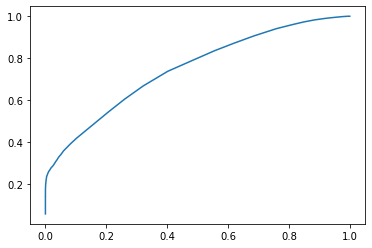

In [ ]:
plt.pyplot.plot(rfROC['FPR'], rfROC['TPR'])

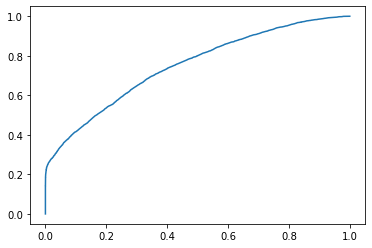

In [ ]:
plt.pyplot.plot(gbtROC['FPR'], gbtROC['TPR'])

### Load and get best features

In [106]:
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.classification import RandomForestClassificationModel

persistedModel = RandomForestClassificationModel.load("/home/jovyan/SherLock/models/rf_model")

In [108]:
preds = persistedModel.transform(test)

In [131]:
from pyspark.ml.classification import RandomForestClassifier
featImps = persistedModel.featureImportances

In [145]:
featureNames = ['CpuGHz', 'CPU_0', 'CPU_1','CPU_2', 'CPU_3', 'Traffic_MobileRxBytes', 'Traffic_MobileRxPackets', 'Traffic_MobileTxBytes', 'Traffic_MobileTxPackets', 'Traffic_TotalWifiRxBytes', 'Traffic_TotalWifiRxPackets', 'Traffic_TotalWifiTxBytes', 'Traffic_TotalWifiTxPackets']

In [150]:
print(len(featureNames))
print(len(featImps))

13
17


In [153]:
featsDF = pd.DataFrame(columns = ['feature', 'importance'])
for feat in featImps:
    print(feat)

0.058324498228448665
0.08905141581938969
0.026195291141217943
0.025152576881328326
0.024023290265434254
0.05395108328049349
0.05116106328635358
0.03076296360947355
0.05769145203140399
0.0720544109646006
0.057219607979956066
0.0893004024994682
0.04379398039299677
0.08596818103567494
0.06735573660309949
0.09148672217947164
0.07650732380118887


### Future steps would be to find a way to map these values back to the feature names. However, we have no way to do that with PySpark, which may or may not keep track of order